#### Initalizing Variables and Preprocessing Datasets

##### Packages

In [2]:
import pywt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_wavelets.Layers.DWT as wavelet
from keras.preprocessing.image import ImageDataGenerator

##### Constents

In [3]:
TRAIN_DATA_PATH = "Data/train"
VALID_DATA_PATH = "Data/valid"
TEST_DATA_PATH  = "Data/test"
BATCH_SIZE      = 16
TARGET_SIZE     = (227,227)
INPUT_SHAPE     = [227,227,3]

##### Data Preprocessing

###### Training Data Preprocessing

In [4]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale = 1.0/255.0,
                                                                        horizontal_flip = True,
                                                                        fill_mode = 'nearest',
                                                                        zoom_range=0.2,
                                                                        shear_range = 0.2,
                                                                        width_shift_range=0.2,
                                                                        height_shift_range=0.2,
                                                                        rotation_range=0.4)

train_data = train_data_generator.flow_from_directory(  TRAIN_DATA_PATH,
                                                        batch_size = BATCH_SIZE,
                                                        target_size = TARGET_SIZE,
                                                        class_mode = 'categorical')

Found 613 images belonging to 4 classes.


###### Validation Data Preprocessing

In [5]:
validation_data_generator = ImageDataGenerator(rescale = 1.0/255.0)

validation_data = validation_data_generator.flow_from_directory(     VALID_DATA_PATH,
                                                        target_size = TARGET_SIZE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = 'categorical')

Found 72 images belonging to 4 classes.


#### Initalizing Convolutional Neural Networks

##### Abstract Class

In [8]:
class CNNModel:
    def __init__(self, input_shape=0, model_type='', model_path=None):
        self.model_type = model_type
        self.history = None
        self.history_accuracy = []
        self.history_val_accuracy = []
        self.history_loss = []
        self.history_val_loss = []
        self.input_shape = input_shape
        self.model = tf.keras.models.Sequential()
        if(model_path==None):
            self.model_path = 'savedModel/CNNModel.ckpt'
        else:
            self.model_path = model_path
        self.model_checkpoint = tf.keras.callbacks.ModelCheckpoint(self.model_path,save_weights_only=True,verbose=1)

    def fit(self,train_data, validation_data, epochs):
        self.history = self.model.fit(x = train_data, validation_data = validation_data, epochs = epochs, callbacks=[self.model_checkpoint])
        self.history_accuracy.extend(self.history.history['accuracy'])
        self.history_val_accuracy.extend(self.history.history['val_accuracy'])
        self.history_loss.extend(self.history.history['loss'])
        self.history_val_loss.extend(self.history.history['val_loss'])

    def plotAccuracy(self):
        if(self.history != None):
            print(self.history.history.keys())
            plt.plot(self.history_accuracy)
            plt.plot(self.history_val_accuracy)
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train','test'], loc='upper left')
            plt.show()
        
    def plotLoss(self):
        if(self.history != None):
            plt.plot(self.history_loss)
            plt.plot(self.history_val_loss)
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()

    def compareAccuracy(models):
        modelList = []
        for model in models:
            if(model.history != None):
                plt.plot(model.history_accuracy)
                modelList.append(model.model_type)
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(modelList, loc='upper left')
        plt.show()

    def compareLoss(models):
        modelList = []
        for model in models:
            if(model.history != None):
                plt.plot(model.history_loss)
                modelList.append(model.model_type)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(modelList, loc='upper left')
        plt.show()

    def predict(self, path):
        classes_dir = ["Adenocarcinoma","Large cell carcinoma","Normal","Squamous cell carcinoma"]
        image = tf.keras.utils.load_img(path, target_size=TARGET_SIZE)
        normalizedImage = tf.keras.utils.img_to_array(image)/255
        imageArray = np.array([normalizedImage])
        predtionResult = np.argmax(self.model.predict(imageArray))
        print(classes_dir[predtionResult])

    def load(self,model_path=None):
        if(model_path==None):
            self.model.load_weights(self.model_path)
        else:
            self.model.load_weights(model_path)

##### AlexNet

In [9]:
class AlexNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/AlexNet.ckpt'):

        super().__init__(input_shape=input_shape,model_type="AlexNet",model_path=model_path)
        self.model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=11, activation='relu', strides=4, input_shape=input_shape))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])

##### Wavelet AlexNet

In [10]:
class WaveletAlexNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/WaveletAlexNet.ckpt'):
        opt = tf.keras.optimizers.SGD(momentum=0.9)

        super().__init__(input_shape=input_shape,model_type="WaveletAlexNet",model_path=model_path)
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=5, activation='relu', strides=4, input_shape=input_shape))

        self.model.add(wavelet.DWT(name='bd2'))
        self.model.add(tf.keras.layers.Reshape((112, 112, 96)))

        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'))
        self.model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
        self.model.add(tf.keras.layers.Flatten(input_shape = (2,2,384)))
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4096, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.5))
        self.model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])

##### ResNet

In [8]:
class ResNet(CNNModel):
    def __init__(self,input_shape=0,model_path='savedModel/ResNet.h5'):
        if(input_shape==0):
            super().__init__(input_shape=input_shape,model_type="ResNet",model_path=model_path)
        else:
            super().__init__(input_shape=input_shape,model_type="ResNet")
            inputs = tf.keras.Input(shape=input_shape)
            x = self.convolutional_block(inputs, 96)
            res = self.residualBlock(x=x, kernel_size=11, filters=96)
            x = self.convolutional_block(x, 96)
            x = tf.keras.layers.Add()([x, res])
        
            x = tf.keras.layers.Flatten()(x)
            x = tf.keras.layers.Dense(units=4096, activation='relu')(x)
            x = tf.keras.layers.Dropout(0.5)(x)
            outputs = tf.keras.layers.Dense(units=4, activation='softmax')(x)

            self.model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

            self.model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics = ['accuracy'])

    def residualBlock(self, x, kernel_size, filters):
        fx = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
        fx = tf.keras.layers.BatchNormalization()(fx)
        fx = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(fx)
        out = tf.keras.layers.Add()([x,fx])
        out = tf.keras.layers.ReLU()(out)
        out = tf.keras.layers.BatchNormalization()(out)
        return out

    def convolutional_block(self,x, filter):
        x_skip = x
        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
        x = tf.keras.layers.Add()([x, x_skip])     
        x = tf.keras.layers.Activation('relu')(x)
        return x



#### MAIN

In [10]:
#alexNet = AlexNet(INPUT_SHAPE)

In [11]:
alexNet.load()

In [18]:
alexNet.fit(train_data, validation_data, 64)

Epoch 1/64
39/39 [==============================] - ETA: 0s - loss: 0.1271 - accuracy: 0.9560
Epoch 1: saving model to savedModel\AlexNet.ckpt
39/39 [==============================] - 5s 127ms/step - loss: 0.1271 - accuracy: 0.9560 - val_loss: 0.8012 - val_accuracy: 0.7917
Epoch 2/64
39/39 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9315
Epoch 2: saving model to savedModel\AlexNet.ckpt
39/39 [==============================] - 5s 132ms/step - loss: 0.1833 - accuracy: 0.9315 - val_loss: 0.6531 - val_accuracy: 0.8194
Epoch 3/64
39/39 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9478
Epoch 3: saving model to savedModel\AlexNet.ckpt
39/39 [==============================] - 5s 134ms/step - loss: 0.1316 - accuracy: 0.9478 - val_loss: 0.5723 - val_accuracy: 0.8056
Epoch 4/64
39/39 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9201
Epoch 4: saving model to savedModel\AlexNet.ckpt
39/39 [============================

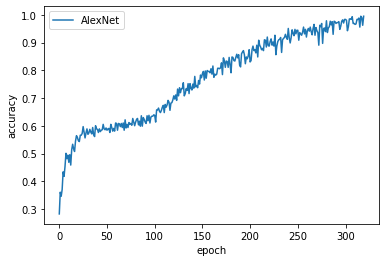

In [20]:
CNNModel.compareAccuracy([alexNet])

In [19]:
alexNet.predict("Data/test/adenocarcinoma/000114.png")

1/1 [==============================] - 0s 12ms/step
Squamous cell carcinoma


In [ ]:
waveletAlexNet.predict("Data/test/adenocarcinoma/000114.png")

1/1 [==============================] - 0s 332ms/step
Adenocarcinoma
